In [18]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
import scipy.optimize as sco
import scipy.interpolate as sci
import matplotlib.pyplot as plt


In [6]:
# create a list of symbols
symbols = [
    "XOM", "SHW", "JPM", "AEP", "UNH", "AMZN",
    "KO", "BA", "AMT", "DD", "TSN", "SLG"
]

# instantiate data frame container
asset_data = pd.DataFrame()

# for loop to get data from yahoo finance
for sym in symbols:
    # each run of the loop returns a pandas dataframe
    asset_data[sym] = web.DataReader(
        name = sym,
        data_source = 'yahoo',
        start = '2011-09-13',
        end = '2022-01-09'
        )['Adj Close'] # use [] to extract values as pandas series

# set column indicies
asset_data.columns = symbols

# examine the first 5 rows
print(asset_data.head(n = 5))

                  XOM        SHW        JPM        AEP        UNH        AMZN  \
Date                                                                            
2011-09-13  46.767792  22.160664  24.298927  25.132013  40.635418  219.529999   
2011-09-14  47.413982  22.852444  24.530779  25.355360  41.219669  222.570007   
2011-09-15  48.308212  22.669762  25.286148  25.477205  42.794624  226.779999   
2011-09-16  48.660694  22.570936  25.001944  25.395979  42.980900  239.300003   
2011-09-19  48.105869  22.361303  24.298927  25.402742  42.295052  241.690002   

                   KO         BA        AMT         DD        TSN        SLG  
Date                                                                          
2011-09-13  24.885937  51.101665  43.927036  20.775400  14.389364  47.528111  
2011-09-14  25.127239  51.248016  44.973312  21.249184  14.440358  49.112377  
2011-09-15  25.577414  52.296883  45.554573  21.912476  14.856827  51.099895  
2011-09-16  25.653042  53.158733  45.

In [7]:
# compute daily simple returns
daily_returns = (
    asset_data.pct_change()
        .dropna(
            #drop the first row since we have NaN's
            # the first date 2011-09-13 does not have a vlaue since it is our cut off date
            axis = 0,
            how = 'any',
            inplace = False
            )
)

# examine the last 5 rows 
daily_returns.tail(n=5)

,XOM,SHW,JPM,AEP,UNH,AMZN,KO,BA,AMT,DD,TSN,SLG
Date,,,,,,,,,,,,
2022-01-03,0.038405,-0.037029,0.021156,-0.004046,0.000279,0.022118,0.001520,0.032486,-0.020923,-0.001485,0.007343,0.045607
2022-01-04,0.037614,-0.010026,0.037910,0.000451,-0.022657,-0.016916,0.016695,0.027759,-0.012606,0.023308,0.019818,0.041483
2022-01-05,0.012437,0.001877,-0.018282,0.009250,-0.002465,-0.018893,0.008293,-0.002621,-0.064363,-0.009087,0.002010,-0.005891
2022-01-06,0.023521,-0.008295,0.010624,-0.003241,-0.040924,-0.006711,-0.005264,-0.008119,0.001210,0.002445,0.012483,0.025767
2022-01-07,0.008197,-0.030999,0.009908,0.018166,-0.023528,-0.004288,-0.002315,0.019684,0.006380,0.014636,0.001871,0.004145


In [8]:
print(daily_returns.mean() * 253)

XOM     0.067752
SHW     0.290469
JPM     0.227013
AEP     0.142875
UNH     0.268022
AMZN    0.309946
KO      0.101049
BA      0.206689
AMT     0.201667
DD      0.181873
TSN     0.219382
SLG     0.107443
dtype: float64


In [9]:
print(daily_returns.cov() * 253)

           XOM       SHW       JPM       AEP       UNH      AMZN        KO  \
XOM   0.062275  0.022145  0.043261  0.014565  0.025596  0.017546  0.020559   
SHW   0.022145  0.058815  0.029115  0.014315  0.025832  0.024323  0.017196   
JPM   0.043261  0.029115  0.078467  0.014909  0.033579  0.024114  0.023092   
AEP   0.014565  0.014315  0.014909  0.037147  0.016198  0.009012  0.018473   
UNH   0.025596  0.025832  0.033579  0.016198  0.064306  0.023700  0.018075   
AMZN  0.017546  0.024323  0.024114  0.009012  0.023700  0.095145  0.012403   
KO    0.020559  0.017196  0.023092  0.018473  0.018075  0.012403  0.030935   
BA    0.050148  0.032212  0.057641  0.019934  0.035834  0.028277  0.028441   
AMT   0.016880  0.022938  0.022745  0.022470  0.022807  0.020809  0.020266   
DD    0.043295  0.034030  0.053351  0.016088  0.031429  0.026881  0.022206   
TSN   0.025284  0.021938  0.027748  0.012826  0.020143  0.013044  0.016495   
SLG   0.045833  0.027830  0.055769  0.025559  0.033029  0.019309

In [10]:
# Function for computing portfolio return
def portfolio_returns(weights):
    return (np.sum(daily_returns.mean() * weights)) * 253

# function for computing standard deviation of portfolio returns
def portfolio_sd(weights):
    return np.sqrt(np.transpose(weights) @ (daily_returns.cov() * 253) @ weights)


In [12]:
# instantiate empy list containers for returns and sd

list_portfolio_returns = []
list_portfolio_sd = []

# loop to simulate 5000 random weight vectors (numpy array objects)
for p in range(5000):
    # return random floats in the half open interval [0.0, 1.0]
    weights = np.random.random(size = len(symbols))
    # normalize to unity
    # the /= operator divides the array by the sum of the array and rebinds "weights" to the new object
    weights /= np.sum(weights)
    # lists are mutable so growing will not be memory inefficient
    list_portfolio_returns.append(portfolio_returns(weights))
    list_portfolio_sd.append(portfolio_sd(weights))
    # convert list to numpy arrays
    port_returns = np.array(object = list_portfolio_returns)
    port_sd = np.array(object = list_portfolio_sd)

# max expected return
max_expected_return = round(max(port_returns), 4)
print(max_expected_return)

# min expected return
min_expected_return = round(min(port_returns), 4)
print(min_expected_return)

0.2364
0.1398


In [15]:
# max sd 
max_expected_sd = round(max(port_sd), 4)
print(max_expected_sd)

# min sd
min_expected_sd = round(min(port_sd), 4)
print(min_expected_sd)

0.226
0.1561


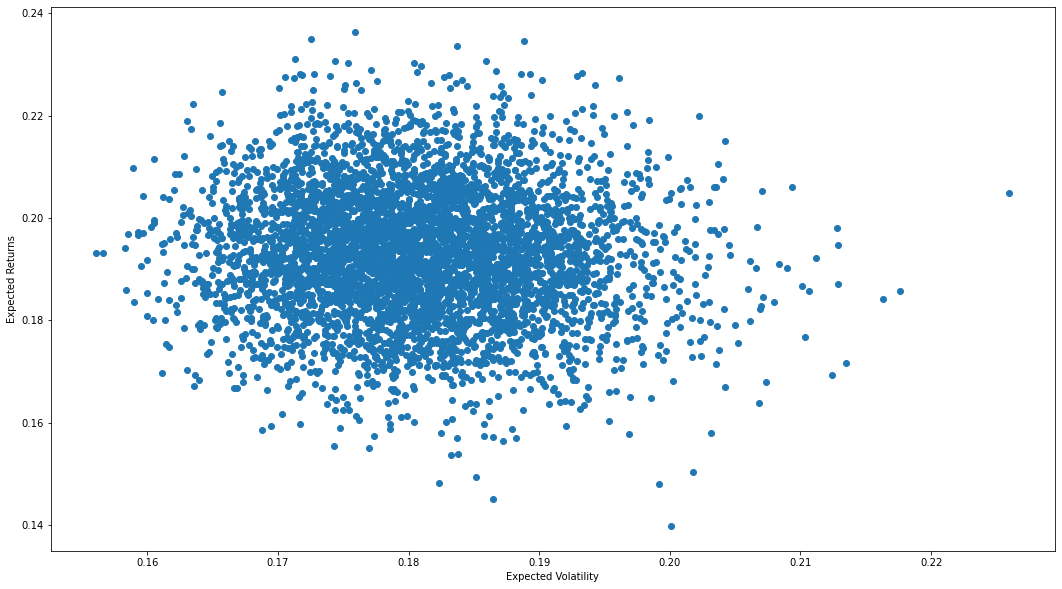

In [25]:
# Plot the sub-optimal portfolios
plt.figure(figsize=(18,10))
plt.scatter(port_sd, port_returns) # c = sharpRatio makes a color map of where the high sharpe ratio is
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Returns')
plt.show()

In [26]:
# user defined sharpe ratio function
# negative sign t ocompute the negative value of sharpe ratio

def sharpe_fun(weights):
    return - (portfolio_returns(weights) / portfolio_sd(weights))

In [27]:
# we will use dictionaires inside of a tuple to represent the constraints:
# we use an anonymous lambda function

constraints = ({'type': 'eq', 'fun': lambda x : np.sum(x) - 1})

In [28]:
# next, the bound values for the weights:
# this creates 12 tuples of (0,1), all of twhich exist within a container typle
# we essentially create a sequence of (min, max) pairs

bounds = tuple(
    (0, 1) for w in weights
)

In [29]:
# we also need to supply a starting list of weights, which essentially functions as an initial guess.
# for our purposes this will be an equal weight array:
# repeat the list with the value (1/12) 12 times, and convert list to array

equal_weights = np.array(
    [1 / len(symbols)] * len(symbols)
)

In [30]:
# minimization results
max_sharpe_results = sco.minimize(
    # objective function
    fun = sharpe_fun,
    # initial guess, which is the equal weight array
    x0 = equal_weights,
    method = 'SLSQP',
    bounds = bounds,
    constraints = constraints
)

In [32]:
# extract the weight composition array
print(max_sharpe_results["x"])

[0.00000000e+00 2.99620847e-01 3.96269499e-17 1.10889083e-01
 1.93565042e-01 2.08902488e-01 0.00000000e+00 2.26259718e-17
 6.59298316e-02 0.00000000e+00 1.21092708e-01 7.93708631e-17]


In [33]:
# expected return
max_sharpe_port_return = portfolio_returns(max_sharpe_results["x"])
round(max_sharpe_port_return, 4)

0.2594

In [35]:
# standard deviation
max_sharpe_port_sd = portfolio_sd(max_sharpe_results["x"])
round(max_sharpe_port_sd, 4)

0.1729

In [36]:
# sharpe ratio
max_sharpe_port_sharpe = max_sharpe_port_return / max_sharpe_port_sd
round(max_sharpe_port_sharpe, 4)

1.5005

In [37]:
#                                                minimum variance portfolio 

In [38]:
# minimize sd
min_sd_results = sco.minimize(
    # objective function
    fun = portfolio_sd,
    # iniital guess, which is the equal weight array
    x0 = equal_weights,
    method = 'SLSQP',
    bounds = bounds,
    constraints = constraints
)

In [39]:
# expected return
min_sd_port_return = portfolio_returns(min_sd_results["x"])
round(min_sd_port_return, 4)

0.1681

In [40]:
# standard deviation 
min_sd_port_sd = portfolio_sd(min_sd_results["x"])
round(min_sd_port_sd, 4)

0.1473

In [41]:
# sharpe ratio 
min_sd_port_sharpe = min_sd_port_return / min_sd_port_sd
round(min_sd_port_sharpe, 4)

1.141

In [42]:
#                                         efficient frontier

In [43]:
# For the optimization, we essentially “fit” the twin-objective described earlier into an optimization problem 
# that can be solved using quadratic programming. (The objective function is the portfolio standard deviation 
# formula, which is a quadratic function) Therefore, the two linear constraints are the target return (a linear 
# function) and that the weights must sum to 1 (another linear function). We will again use dictionaries inside 
# of a tuple to represent the constraints:

# we use anonymous lambda functions
# the argument x will be the weights
constraints = (
    {'type': 'eq', 'fun': lambda x: portfolio_returns(x) - target},
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
)

In [44]:
# this creates 12 tuples of (0, 1), all of which exist within a container tuple
# we essentially create a sequence of (min, max) pairs

bounds = tuple(
    (0, 1) for w in weights
)

In [45]:
# in itialise an array of target returns

target = np.linspace(
    start = 0.15,
    stop = 0.30,
    num = 100
)

# instantiate empty container for the objective values to be minimized
obj_sd = []
# for loop to minimize objective function
for target in target:
    min_result_object = sco.minimize(
        # objective function
        fun = portfolio_sd,
        # initial guess, which is the equal weight array
        x0 = equal_weights,
        method = 'SLSQP',
        bounds = bounds,
        constraints = constraints
        )
    # extract the objective value and append it to the output container
    obj_sd.append(min_result_object['fun'])
# end of loop
# convert list to array
obj_sd = np.array(obj_sd)

# rebind target to a new array object
target = np.linspace(
    start = 0.15,
    stop = 0.30,
    num = 100
)

In [ ]:
# plt.figure(figsize=(18,10))
# plt.scatter(expectedVolatality, expectedReturn, c=sharpRatio) # c = sharpRatio makes a color map of where the high sharpe ratio is
# plt.xlabel('Expected Volatility')
# plt.ylabel('Expected Returns')
# plt.colorbar(label = 'Sharpe Ratio') # legend for the color map
# plt.scatter(expectedVolatality[maxIndex], expectedReturn[maxIndex], c ='red') # plotting the max sharpe ratio point
# plt.scatter(x_values, y_values, marker = 'X', color = 'orange')
# plt.plot(annualised_volatility_opt, returns)
# plt.show()

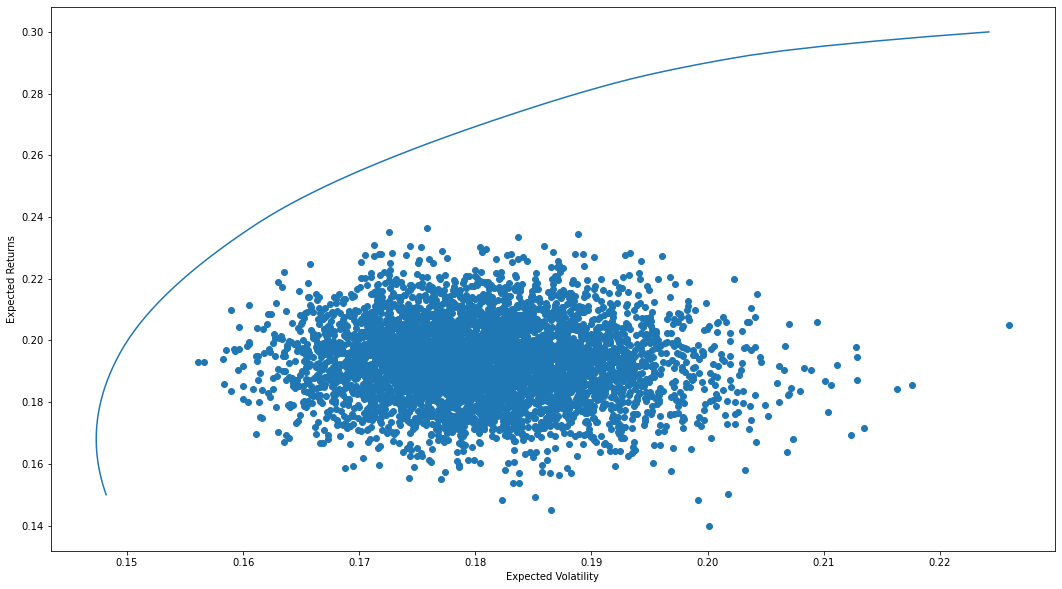

In [46]:
# Plot the sub-optimal portfolios
plt.figure(figsize=(18,10))
plt.scatter(port_sd, port_returns) # c = sharpRatio makes a color map of where the high sharpe ratio is
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Returns')
plt.plot(obj_sd, target)
plt.show()